In [52]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import StratifiedKFold

In [53]:
path = './input/'
comp = 'germeval2018/'
TRAIN_DATA_FILE=f'{path}{comp}germeval2018.training.txt'
TEST_DATA_FILE=f'{path}{comp}germeval2018.sample.txt'
EMBEDDING_FILE=f'{path}embed_tweets_de_200M_200D/embedding_file'


In [ ]:
# same seed to make classifier output reproducible
from numpy.random import seed
seed = 1
np.random.seed(seed)

In [55]:
embed_size = 200 # how big is each word vector
max_features = 15909 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

# Preprocessing

In [5]:
import re
import re
import sys


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URLTOK ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USRTOK', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', 'rt', tweet)
    words = tweet.split()

    for word in words:
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

Read in our data 

In [56]:
train = pd.read_csv(TRAIN_DATA_FILE, sep="\t", header=None)
#perform binary classification
train = train[[1,0]]
train.columns = ['sentiment', 'tweet_text']
train.applymap(lambda x: x.strip() if type(x) is str else x)
train['tweet_text'] = train['tweet_text'].apply(lambda x: preprocess_tweet(x))


mapping = {'OTHER': 0, 'OFFENSE': 1}
train = train.replace({'sentiment': mapping})
#df_clas_data['sentiment'] = df_clas_data['sentiment'].str.strip()
train['sentiment'] = train['sentiment'].astype(np.float32)

list_sentences_train = train.tweet_text
y_train = train['sentiment'].values



In [57]:
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
#perform binary classification
test = test[[1,0]]
test.columns = ['sentiment', 'tweet_text']
test.applymap(lambda x: x.strip() if type(x) is str else x)
test['tweet_text'] = test['tweet_text'].apply(lambda x: preprocess_tweet(x))


mapping = {'OTHER': 0, 'OFFENSE': 1}
test = test.replace({'sentiment': mapping})
#df_clas_data['sentiment'] = df_clas_data['sentiment'].str.strip()
test['sentiment'] = test['sentiment'].astype(np.float32)

list_sentences_test = test.tweet_text
y_test = test.sentiment.values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [58]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [59]:
X_t

array([[    0,     0,     0, ...,  2173,    62,  5990],
       [    0,     0,     0, ...,  5991,  1318,    18],
       [    0,     0,     0, ...,   163,  3737,  3738],
       ...,
       [    0,     0,     0, ...,   912,    38,   354],
       [    0,     0,     0, ...,     3, 15905,  1860],
       [    0,     0,     0, ...,  1417,    15, 15908]], dtype=int32)

Read the SpinningBytes word vectors (space delimited strings) into a dictionary from word->vector.

In [60]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [61]:
values = embeddings_index.values()
for val in values:
    if len(val) != 200:
        print(len(val))

In [62]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.00042068152, 0.24969141)

Use these vectors to create our embedding matrix, with random initialization for words that aren't in the word embeddings. We'll use the same mean and stdev of embeddings the tweet embeddings have when generating the random init.

In [63]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [64]:
min(max_features, len(word_index))

15908

In [65]:
word_index

{'usrtok': 1,
 'die': 2,
 'der': 3,
 'und': 4,
 'das': 5,
 'ist': 6,
 'lbr': 7,
 'in': 8,
 'nicht': 9,
 'ich': 10,
 'es': 11,
 'sie': 12,
 'zu': 13,
 'den': 14,
 'für': 15,
 'ein': 16,
 'mit': 17,
 'wir': 18,
 'von': 19,
 'auch': 20,
 'sich': 21,
 'sind': 22,
 'auf': 23,
 'hat': 24,
 'nur': 25,
 'eine': 26,
 'was': 27,
 'so': 28,
 'wie': 29,
 'im': 30,
 'noch': 31,
 'man': 32,
 'aber': 33,
 'haben': 34,
 'als': 35,
 'wird': 36,
 'wenn': 37,
 'werden': 38,
 'bei': 39,
 'an': 40,
 'aus': 41,
 'merkel': 42,
 'dem': 43,
 'schon': 44,
 'ihr': 45,
 'oder': 46,
 'da': 47,
 'dass': 48,
 'deutschland': 49,
 'keine': 50,
 'er': 51,
 'uns': 52,
 'um': 53,
 'mehr': 54,
 'kann': 55,
 'dann': 56,
 'doch': 57,
 '😜': 58,
 'mal': 59,
 'ja': 60,
 'diese': 61,
 'du': 62,
 'einen': 63,
 'über': 64,
 'jetzt': 65,
 'alle': 66,
 'nach': 67,
 'immer': 68,
 'mir': 69,
 'des': 70,
 'war': 71,
 'heute': 72,
 'u': 73,
 'wieder': 74,
 'vor': 75,
 'mich': 76,
 'wer': 77,
 'gibt': 78,
 'zum': 79,
 'am': 80,
 'd': 81

In [66]:
y_train_one_hot = np.zeros((X_t.shape[0], 2))
y_train_one_hot[np.arange(X_t.shape[0]),y_train.astype(np.int32)] = 1
y_test_one_hot = np.zeros((X_te.shape[0], 2))
y_test_one_hot[np.arange(X_te.shape[0]),y_test.astype(np.int32)] = 1

Simple CNN

In [38]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_t, y_train):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Conv1D(128, 5, activation='relu')(x) 
    x = MaxPooling1D(5)(x)
    #x = Conv1D(64, 5, activation='relu')(x) #added 
    #x = MaxPooling1D(5)(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    
    x = Flatten()(x)
    #x = Dense(64, activation='relu')(x) 
    preds = Dense(2, activation='softmax')(x) 
    
    model = Model(inputs=inp, outputs=preds)
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy']) #changed optimizer from 'adam' to custom adam
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

    model.fit(X_t[train], y_train_one_hot[train], batch_size=32, epochs=10, validation_split=0.1, shuffle=True, callbacks=[reduce_lr,early_stopping]);

    scores = model.evaluate(X_t[test], y_train_one_hot[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 4056 samples, validate on 451 samples
Epoch 1/10
4056/4056 [==============================] - 9s 2ms/step - loss: 0.6494 - acc: 0.6543 - val_loss: 0.6337 - val_acc: 0.6829
Epoch 2/10
4056/4056 [==============================] - 5s 1ms/step - loss: 0.5680 - acc: 0.7034 - val_loss: 0.5473 - val_acc: 0.7317
Epoch 3/10
4056/4056 [==============================] - 5s 1ms/step - loss: 0.3848 - acc: 0.8299 - val_loss: 0.5399 - val_acc: 0.7494
Epoch 4/10
4056/4056 [==============================] - 5s 1ms/step - loss: 0.1915 - acc: 0.9231 - val_loss: 0.6161 - val_acc: 0.7627
Epoch 5/10
4056/4056 [==============================] - 5s 1ms/step - loss: 0.0875 - acc: 0.9689 - val_loss: 0.8141 - val_acc: 0.7472
acc: 75.50%
Train on 4057 samples, validate on 451 samples
Epoch 1/10
4057/4057 [==============================] - 9s 2ms/step - loss: 0.6448 - acc: 0.6589 - val_loss: 0.5981 - val_acc: 0.6807
Epoch 2/10
4057/4057 [==============================] - 5s 1ms/step - loss: 0.5297 - acc: 

# Serialize model to json

In [39]:
#from keras.models import model_from_json
#model_json = model.to_json()
#with open("CNN_model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("CNN_model.h5")
#print("Saved model to disk")

Saved model to disk


In [80]:
# load json and create model
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("CNN_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])



Loaded model from disk


## Predict probabilities

In [81]:
preds = model.predict(X_te, batch_size=32, verbose=1) # decreased batch size

pred_pos = preds.argmax(-1)
pred_pos = pred_pos.astype(float)
print('Accuracy: ' + str(np.mean(pred_pos == y_test)))

100/100 [==============================] - 6s 63ms/step
Accuracy: 0.91


In [82]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, pred_pos))

             precision    recall  f1-score   support

        0.0       0.94      0.88      0.91        51
        1.0       0.88      0.94      0.91        49

avg / total       0.91      0.91      0.91       100



In [71]:
 # create a submission
submission = pd.DataFrame(columns=['tweet_text', 'probabilities_neutral', 'probabilities_toxic'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['probabilities_neutral'] = preds[:,0] 
submission['probabilities_toxic'] = preds[:,1]
# dummy value
submission.to_csv(f"{path}{comp}CNN_probabilities.csv", sep="\t", index=False, header=False)

## Create file for submission

In [72]:
# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'binary', 'multiclass'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['binary'] = pred_pos 
mapping = {0 :'OTHER', 1: 'OFFENSE'}
submission = submission.replace({'binary': mapping})
# dummy value
submission['multiclass'] = 'OTHER'
submission.to_csv(f"{path}{comp}CNN_submit.csv", sep="\t", index=False, header=False)

# Receiver Operating Characteristics

In [73]:
pred_pos_one_hot = np.zeros((X_te.shape[0], 2))
pred_pos_one_hot[np.arange(X_te.shape[0]),pred_pos.astype(np.int32)] = 1

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


In [75]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds[:,1])

0.9527811124449779

In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_pos)

array([[45,  6],
       [ 3, 46]])

In [77]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    #fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], pred_pos_one_hot[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test, preds[:,i])

    roc_auc[i] = auc(fpr[i], tpr[i])



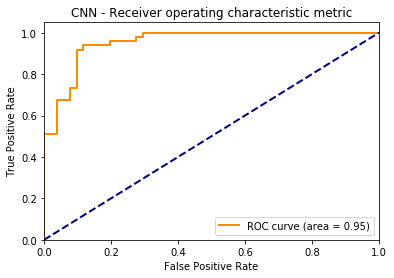

In [78]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN - Receiver operating characteristic metric')
plt.legend(loc="lower right")
plt.show()